In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE,SVMSMOTE,BorderlineSMOTE,ADASYN,KMeansSMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

In [38]:
data = pd.read_csv("E:\竞赛\服创赛-A08\\data\特征集\\new_features.csv")

delete_feature = ['Unnamed: 0','个人编码','救助_补助金总和']
data = data.drop(delete_feature,axis=1)

data.shape

(16000, 377)

In [39]:
nan_counts = data.isna().sum()
for column, count in nan_counts.items():
    if count > 0:
        print(f"Column '{column}' has {count} NaN values.")
    else:
        # 如果列中没有NaN，则不打印任何内容
        pass

In [40]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

In [41]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
# 分离类别
data_0 = data[data.RES == 0]
data_1 = data[data.RES == 1]

# BorderlineSMOTE

In [32]:
# 在计算Minkowski距离时使用n个邻居
bor = BorderlineSMOTE(m_neighbors=5,
                       kind='borderline-1'  # # 使用Borderline SMOTE变体
                       )

X_smote,y_smote = bor.fit_resample(X_train,y_train)

# SVMSMOTE

In [34]:
# 设置合成样本的步长
svm = SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=-1)
X_smote,y_smote = svm.fit_resample(X_train,y_train)

D:\Anaconda3\envs\A08\lib\site-packages\imblearn\over_sampling\_smote\filter.py:437: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


# ADASYN

In [23]:
# 创建ADASYN实例
adasyn = ADASYN(
    sampling_strategy='auto',
    n_neighbors=2,
    random_state=42)

X_smote,y_smote = adasyn.fit_resample(X_train,y_train)

# SMOTE

In [9]:
# 应用SMOTE过采样
smote = SMOTE(
    sampling_strategy=0.5,  # 将少数类样本过采样到多数类样本数的50%
    k_neighbors=2, # 使用5个最近邻来构造合成样本
    n_jobs=-1,  # 使用所有可用的CPU核心进行并行处理
    random_state=42)

X_smote,y_smote = smote.fit_resample(X_train,y_train)

# KMeansSMOTE

In [33]:
# 初始化 KMeansSMOTE
kmeans_smote = KMeansSMOTE(
    k_neighbors=2,
    # n_clusters=10,
    random_state=42,
    sampling_strategy='auto',
    cluster_balance_threshold=0.1,
    n_jobs=-1,
    density_exponent=0.5
)

X_smote,y_smote = kmeans_smote.fit_resample(X_train,y_train)

In [35]:
X_smote.shape

(22810, 376)

In [43]:
from sklearn.decomposition import PCA

# 进行PCA降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_smote)

# 提取原始和合成的少数类样本
original_minority = X_pca[y == 1]
synthetic_minority = X_resampled_pca[y_smote == 1]

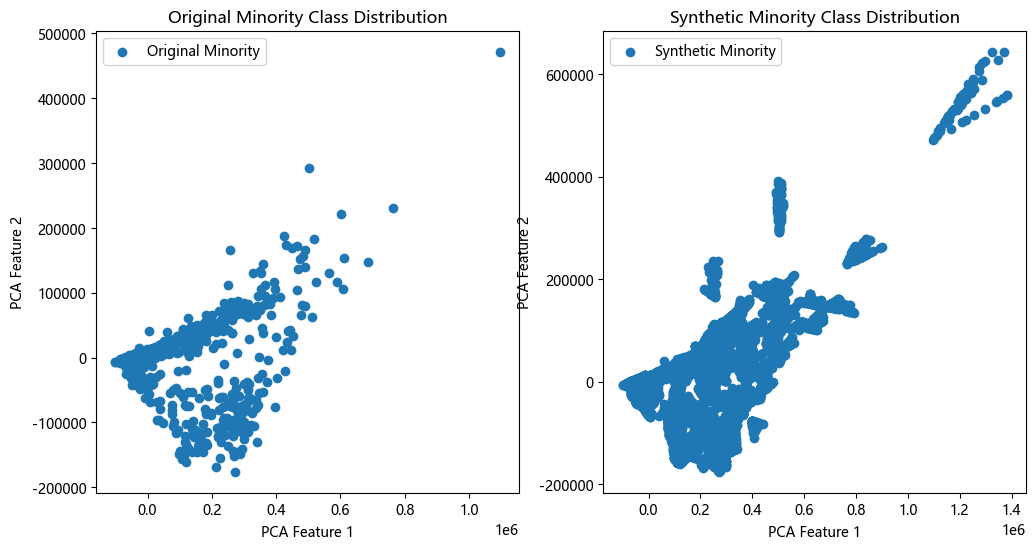

In [44]:
# 可视化
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_minority[:, 0], original_minority[:, 1], label='Original Minority')
plt.title('Original Minority Class Distribution')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(synthetic_minority[:, 0], synthetic_minority[:, 1], label='Synthetic Minority')
plt.title('Synthetic Minority Class Distribution')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()

plt.show()

In [36]:
num1 = sum(y_smote == 1)
num2 = sum(y_smote == 0)
num1,num2

(11405, 11405)

In [27]:
# 构建随机森林模型
# 创建随机森林分类器实例
rf_model = RandomForestClassifier(
    n_estimators=128,       # 树的数量
    # criterion='gini',       # 用于分裂的质量度量，也可以是 'entropy'
    max_depth=None,         # 树的最大深度
    # min_samples_split=2,    # 分裂内部节点所需的最少样本数
    # min_samples_leaf=1,     # 在叶节点处需要的最少样本数
    # min_weight_fraction_leaf=0.0, # 在所有叶子节点处的权重总和中的最小加权分数
    # max_features='sqrt',    # 寻找最佳分割时考虑的特征数量
    # max_leaf_nodes=None,    # 以最佳优先方式增长树时的最大叶子节点数
    # min_impurity_decrease=0.0,    # 如果节点分裂导致不纯度减少大于或等于此值，则分裂节点
    # bootstrap=True,         # 是否在构建树时使用bootstrap样本
    oob_score=False,        # 是否使用袋外样本来估计泛化精度
    n_jobs=-1,              # 拟合和预测时并行运行的作业数
    random_state=42,        # 控制组件的随机性
    verbose=0,              # 控制拟合和预测的冗长程度
    warm_start=True,       # 设置为True时，重用上一个调用的解决方案以适应并在集合中添加更多的估计器
    # class_weight=weight_dict,      # 类别的权重
    # ccp_alpha=0.0,          # 用于最小成本-复杂性剪枝的复杂性参数
    # max_samples=None        # 如果 bootstrap 为 True，从 X 抽取的样本数
)

# 训练模型
rf_model.fit(X_smote, y_smote)

# 在测试集上进行预测
y_pred = rf_model.predict(X_test)

# 获取分类报告
report = classification_report(y_test, y_pred)
print("分类报告:\n", report)

# 计算AUC
# 注意：roc_auc_score需要预测的概率值，不是类别标签
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

分类报告:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      3802
           1       0.52      0.39      0.45       198

    accuracy                           0.95      4000
   macro avg       0.74      0.69      0.71      4000
weighted avg       0.95      0.95      0.95      4000

AUC: 0.9071049793038221


In [42]:
y_pred = rf_model.predict(X_smote)

# 获取分类报告
report = classification_report(y_smote, y_pred)
print("分类报告:\n", report)

# 计算AUC
# 注意：roc_auc_score需要预测的概率值，不是类别标签
y_pred_proba = rf_model.predict_proba(X_smote)[:, 1]
auc = roc_auc_score(y_smote, y_pred_proba)
print("AUC:", auc)

分类报告:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     11405
           1       1.00      0.90      0.95     11405

    accuracy                           0.95     22810
   macro avg       0.95      0.95      0.95     22810
weighted avg       0.95      0.95      0.95     22810

AUC: 0.9999204030166668
